In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import GradientBoostingRegressor
from IPython.display import display
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

In [ ]:
energy_train = pd.read_parquet('Daten/energy_train.parquet')
energy_test2 = pd.read_parquet('Daten/energy_test2.parquet')
energy_test1 = pd.read_parquet('Daten/energy_test1.parquet')
forecasts = pd.read_parquet('Daten/forecasts.parquet')

energy_test1_copy = pd.read_parquet('Daten/energy_test1.parquet')
energy_test1.head()

,dtm,ref_datetime,Solar_capacity_mwp
0,2023-01-01 00:00:00+00:00,2022-12-31 00:00:00+00:00,2262.233423
1,2023-01-01 01:00:00+00:00,2022-12-31 00:00:00+00:00,2262.233423
2,2023-01-01 02:00:00+00:00,2022-12-31 00:00:00+00:00,2262.233423
3,2023-01-01 03:00:00+00:00,2022-12-31 00:00:00+00:00,2262.233423
4,2023-01-01 04:00:00+00:00,2022-12-31 00:00:00+00:00,2262.233423


### Zusammenführen der Wettermodelle

In [3]:
for model in ['DWD ICON', 'NCEP GFS']:
    # Filter für das Wettermodell
    forecasts_model = forecasts[forecasts['Weather Model'] == model].copy()
    
    # Spalten umbenennen
    forecasts_model = forecasts_model.rename(columns={
        'SolarDownwardRadiation': f'SolarDownwardRadiation_{model.replace(" ", "_")}',
        'CloudCover': f'CloudCover_{model.replace(" ", "_")}',
        'Temperature': f'Temperature_{model.replace(" ", "_")}'
    })
    
    # 'valid_datetime' berechnen
    forecasts_model['valid_datetime'] = pd.to_datetime(forecasts_model['ref_datetime']) + pd.to_timedelta(forecasts_model['valid_time'], unit='h')
    
    # Forecast DataFrame für das spezifische Modell speichern
    if model == 'DWD ICON':
        forecasts_dwd = forecasts_model
    else:
        forecasts_ncep = forecasts_model

# Zusammenführen der beiden Modelle
forecasts_combined = pd.merge(
    forecasts_ncep,
    forecasts_dwd, 
    on=['ref_datetime', 'valid_time', 'valid_datetime'], 
    how='inner'
)

forecasts_combined.head()


,ref_datetime,valid_time,SolarDownwardRadiation_NCEP_GFS,CloudCover_NCEP_GFS,Temperature_NCEP_GFS,Weather Model_x,valid_datetime,SolarDownwardRadiation_DWD_ICON,CloudCover_DWD_ICON,Temperature_DWD_ICON,Weather Model_y
0,2020-09-20 00:00:00+00:00,20,0.0,0.0045,13.547716,NCEP GFS,2020-09-20 20:00:00+00:00,-0.010547,0.366211,13.823755,DWD ICON
1,2020-09-20 00:00:00+00:00,21,0.0,0.0020,13.086699,NCEP GFS,2020-09-20 21:00:00+00:00,0.001263,0.471512,13.427564,DWD ICON
2,2020-09-20 00:00:00+00:00,22,0.0,0.0100,12.700010,NCEP GFS,2020-09-20 22:00:00+00:00,0.001532,0.398212,13.093005,DWD ICON
3,2020-09-20 00:00:00+00:00,23,0.0,0.0075,12.443296,NCEP GFS,2020-09-20 23:00:00+00:00,-0.001624,0.292247,12.667871,DWD ICON
4,2020-09-20 00:00:00+00:00,24,0.0,0.0020,12.240011,NCEP GFS,2020-09-21 00:00:00+00:00,-0.008356,0.327759,12.216522,DWD ICON


### Zusammenführen der Energiedaten und Wettervorhersagen

In [4]:
# Merging beide DataFrames basierend auf den Spalten 'dtm' und 'ref_datetime' in energy_train
# sowie 'valid_datetime' und 'ref_datetime' in forecasts_combined (inner join).
energy_train_mit_forecast = pd.merge(
    energy_train, 
    forecasts_combined, 
    left_on=['dtm', 'ref_datetime'], 
    right_on=['valid_datetime', 'ref_datetime'], 
    how='inner'
)

# Entferne Zeilen, bei denen die Zielvariable 'Solar_MWh' NaN ist.
energy_train_mit_forecast = energy_train_mit_forecast[energy_train_mit_forecast["Solar_MWh"].isna() == False]

energy_train_mit_forecast.head()


,dtm,ref_datetime,Solar_capacity_mwp,Solar_MWh,valid_time,SolarDownwardRadiation_NCEP_GFS,CloudCover_NCEP_GFS,Temperature_NCEP_GFS,Weather Model_x,valid_datetime,SolarDownwardRadiation_DWD_ICON,CloudCover_DWD_ICON,Temperature_DWD_ICON,Weather Model_y
0,2020-09-21 00:00:00+00:00,2020-09-20 00:00:00+00:00,2130.510089,0.0,24,0.0,0.002,12.240011,NCEP GFS,2020-09-21 00:00:00+00:00,-0.008356,0.327759,12.216522,DWD ICON
1,2020-09-21 01:00:00+00:00,2020-09-20 00:00:00+00:00,2130.510089,0.0,25,0.0,0.003,12.032483,NCEP GFS,2020-09-21 01:00:00+00:00,0.008838,0.436067,12.015985,DWD ICON
2,2020-09-21 02:00:00+00:00,2020-09-20 00:00:00+00:00,2130.510089,0.0,26,0.0,0.007,11.833379,NCEP GFS,2020-09-21 02:00:00+00:00,0.015384,0.468752,11.813635,DWD ICON
3,2020-09-21 03:00:00+00:00,2020-09-20 00:00:00+00:00,2130.510089,0.0,27,0.0,0.003,11.651335,NCEP GFS,2020-09-21 03:00:00+00:00,-0.008835,0.501229,11.651337,DWD ICON
4,2020-09-21 04:00:00+00:00,2020-09-20 00:00:00+00:00,2130.510089,0.0,28,0.0,0.003,11.484987,NCEP GFS,2020-09-21 04:00:00+00:00,-0.002165,0.514093,11.516748,DWD ICON


In [5]:
# Extrahiere Monat und Jahr aus der Spalte 'dtm' im Format "Monat Jahr"
energy_train_mit_forecast['month_year'] = energy_train_mit_forecast['dtm'].dt.strftime('%B %Y')

# Erhalte eindeutige Werte der Monate und Jahre
unique_months_years = energy_train_mit_forecast['month_year'].unique()

print(unique_months_years)


['September 2020' 'October 2020' 'November 2020' 'December 2020'
 'January 2021' 'February 2021' 'March 2021' 'April 2021' 'May 2021'
 'June 2021' 'July 2021' 'August 2021' 'September 2021' 'October 2021'
 'November 2021' 'December 2021' 'January 2022' 'February 2022'
 'March 2022' 'April 2022' 'May 2022' 'June 2022' 'July 2022'
 'August 2022' 'September 2022' 'October 2022' 'November 2022'
 'December 2022']


###  Generieren neuer Features

Korrelation mit Solar_MWh(Aus Aufgabe 4)

| Feature                                | Korrelation |
|----------------------------------------|-------------|
| SolarDownwardRadiation_DWD_ICON        | 0.952156    |
| SolarDownwardRadiation_NCEP_GFS        | 0.933041    |
| radiation_temp_interaction_DWD_ICON   | 0.866000    |
| radiation_temp_interaction_NCEP_GFS   | 0.853576    |
| CloudRadiationLoss                     | 0.828186    |
| effective_radiation_NCEP_GFS          | 0.779750    |
| effective_radiation_DWD_ICON          | 0.724797    |
   

In [6]:
energy_train_mit_forecast['time'] = energy_train_mit_forecast['dtm'].dt.time  #Stunden extrahieren 
energy_train_mit_forecast['CloudRadiationLoss'] =(energy_train_mit_forecast['SolarDownwardRadiation_DWD_ICON']* energy_train_mit_forecast['CloudCover_DWD_ICON'])
energy_train_mit_forecast['effective_radiation_DWD_ICON'] = energy_train_mit_forecast['SolarDownwardRadiation_DWD_ICON'] * (1 - energy_train_mit_forecast['CloudCover_DWD_ICON'])
energy_train_mit_forecast['effective_radiation_NCEP_GFS'] = energy_train_mit_forecast['SolarDownwardRadiation_NCEP_GFS'] * (1 - energy_train_mit_forecast['CloudCover_NCEP_GFS'])
energy_train_mit_forecast['radiation_temp_interaction_DWD_ICON'] = energy_train_mit_forecast['SolarDownwardRadiation_DWD_ICON'] * energy_train_mit_forecast['Temperature_DWD_ICON'] 
energy_train_mit_forecast['radiation_temp_interaction_NCEP_GFS'] = energy_train_mit_forecast['SolarDownwardRadiation_NCEP_GFS'] * energy_train_mit_forecast['Temperature_NCEP_GFS'] 
energy_train_mit_forecast.head()


,dtm,ref_datetime,Solar_capacity_mwp,Solar_MWh,valid_time,SolarDownwardRadiation_NCEP_GFS,CloudCover_NCEP_GFS,Temperature_NCEP_GFS,Weather Model_x,valid_datetime,...,CloudCover_DWD_ICON,Temperature_DWD_ICON,Weather Model_y,month_year,time,CloudRadiationLoss,effective_radiation_DWD_ICON,effective_radiation_NCEP_GFS,radiation_temp_interaction_DWD_ICON,radiation_temp_interaction_NCEP_GFS
0,2020-09-21 00:00:00+00:00,2020-09-20 00:00:00+00:00,2130.510089,0.0,24,0.0,0.002,12.240011,NCEP GFS,2020-09-21 00:00:00+00:00,...,0.327759,12.216522,DWD ICON,September 2020,00:00:00,-0.002739,-0.005617,0.0,-0.102078,0.0
1,2020-09-21 01:00:00+00:00,2020-09-20 00:00:00+00:00,2130.510089,0.0,25,0.0,0.003,12.032483,NCEP GFS,2020-09-21 01:00:00+00:00,...,0.436067,12.015985,DWD ICON,September 2020,01:00:00,0.003854,0.004984,0.0,0.106196,0.0
2,2020-09-21 02:00:00+00:00,2020-09-20 00:00:00+00:00,2130.510089,0.0,26,0.0,0.007,11.833379,NCEP GFS,2020-09-21 02:00:00+00:00,...,0.468752,11.813635,DWD ICON,September 2020,02:00:00,0.007211,0.008173,0.0,0.181740,0.0
3,2020-09-21 03:00:00+00:00,2020-09-20 00:00:00+00:00,2130.510089,0.0,27,0.0,0.003,11.651335,NCEP GFS,2020-09-21 03:00:00+00:00,...,0.501229,11.651337,DWD ICON,September 2020,03:00:00,-0.004428,-0.004407,0.0,-0.102938,0.0
4,2020-09-21 04:00:00+00:00,2020-09-20 00:00:00+00:00,2130.510089,0.0,28,0.0,0.003,11.484987,NCEP GFS,2020-09-21 04:00:00+00:00,...,0.514093,11.516748,DWD ICON,September 2020,04:00:00,-0.001113,-0.001052,0.0,-0.024936,0.0


### Erstellen von Trainings- und Validierungsset

In [7]:
# Extrahiere Monat und Jahr zur Filterung
energy_train_mit_forecast['month_year'] = energy_train_mit_forecast['dtm'].dt.to_period('M')

# Teile die Daten in Trainings- und Validierungssets auf
# Das Trainings-Set umfasst die Daten mit `month_year` zwischen September 2020 und Juni 2022 (inklusive).
df_train = energy_train_mit_forecast[(energy_train_mit_forecast['month_year'] >= '2020-09') & (energy_train_mit_forecast['month_year'] <= '2022-06')]

# Das Test-Set umfasst die Daten mit `month_year` nach Juni 2022.
df_test = energy_train_mit_forecast[energy_train_mit_forecast['month_year'] > '2022-06']


C:\Users\etzko\AppData\Local\Temp\ipykernel_3372\1734900250.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  energy_train_mit_forecast['month_year'] = energy_train_mit_forecast['dtm'].dt.to_period('M')


### Zu entfernende Spalten

In [8]:
# Liste der zu entfernenden Spalten
columns_to_drop = ["dtm", "ref_datetime", "Weather Model_x", "Weather Model_y", "valid_datetime", "valid_time", 'month_year',
                   "CloudCover_NCEP_GFS", "CloudCover_DWD_ICON", "Temperature_NCEP_GFS", "Temperature_DWD_ICON", "Solar_capacity_mwp"] 

# Entfernen der definierten Spalten
df_train = df_train.drop(columns=columns_to_drop)


In [9]:
categorical_features = ["time"] 
numerical_features = ["SolarDownwardRadiation_DWD_ICON", "SolarDownwardRadiation_NCEP_GFS", "CloudRadiationLoss", "effective_radiation_DWD_ICON",
                     "effective_radiation_NCEP_GFS", "radiation_temp_interaction_DWD_ICON", "radiation_temp_interaction_NCEP_GFS"  ]

In [10]:
# Entfernen des Labels aus den Daten
y_train= df_train.pop("Solar_MWh")
y_test= df_test.pop("Solar_MWh")

In [11]:
X_train = df_train
X_test = df_test

In [12]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15504 entries, 0 to 15503
Data columns (total 8 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   SolarDownwardRadiation_NCEP_GFS      15438 non-null  float64
 1   SolarDownwardRadiation_DWD_ICON      15457 non-null  float64
 2   time                                 15504 non-null  object 
 3   CloudRadiationLoss                   15457 non-null  float64
 4   effective_radiation_DWD_ICON         15457 non-null  float64
 5   effective_radiation_NCEP_GFS         15425 non-null  float64
 6   radiation_temp_interaction_DWD_ICON  15457 non-null  float64
 7   radiation_temp_interaction_NCEP_GFS  15431 non-null  float64
dtypes: float64(7), object(1)
memory usage: 1.1+ MB


### Columntransformer and pipeline

In [13]:
# Ziel: Vorverarbeitung der Daten (kategoriale und numerische Features) in separaten Pipelines.
column_trans = ColumnTransformer(
    transformers=[
        # 1. Vorverarbeitung der kategorialen Features:
        #    a) Fehlende Werte (NaN) in kategorialen Spalten durch die häufigste Kategorie ersetzen ("most_frequent").
        #    b) One-hot Encoding für kategoriale Features, um sie in numerische Werte zu transformieren.
        ("onehot", Pipeline([
            ("impute", SimpleImputer(strategy="most_frequent")),  # Fehlende Werte ersetzen
            ("encode", OneHotEncoder(handle_unknown="ignore"))  # One-hot Encoding
        ]), categorical_features),  # Liste der kategorialen Features
        
        # 2. Vorverarbeitung der numerischen Features:
        #    a) Skalierung der numerischen Spalten, um sie standardisiert (Mittelwert=0, Varianz=1) darzustellen.
        ("impute_scale", Pipeline([
            ("impute", SimpleImputer(strategy="mean")),   # Fehlende Werte ersetzen
            ("scale", StandardScaler())  # Skalierung der numerischen Daten
        ]), numerical_features)  # Liste der numerischen Features
    ],
    # Alle anderen Spalten werden unverändert beibehalten (falls vorhanden), da `remainder="passthrough"` angegeben ist.
    remainder="passthrough"
)


## Aufgabe 5

### Einfache lineare Regression

In [14]:
# Definition einer Pipeline mit Preprocessing und LinearRegression-Modell
linear_pipe = Pipeline([
    ('preprocessing', column_trans),  # Vorverarbeitung der Eingabedaten
    ('model', LinearRegression())    # Lineares Regressionsmodell
])

# Parameter-Grid für das Modell (leer, da keine Hyperparameter optimiert werden)
linear_param_grid = {}

# GridSearchCV zur Optimierung des Modells
linear_gs = GridSearchCV(
    estimator=linear_pipe,                    # Pipeline als Estimator
    param_grid=linear_param_grid,             # Parameter-Grid
    scoring='neg_root_mean_squared_error',    # Bewertungsmetrik (negativer RMSE)
    cv=5,                                     # Kreuzvalidierung mit 5 Folds
    n_jobs=-1                                 # Parallele Verarbeitung
)

# Fit des Modells auf die Trainingsdaten
linear_gs.fit(X_train, y_train)

# Bestes Modell und Trainings-RMSE (basierend auf Kreuzvalidierung)
linear_best_model = linear_gs.best_estimator_
linear_train_rmse = np.sqrt(-linear_gs.best_score_)

# Vorhersage auf dem Test-Datensatz und Berechnung des Test-RMSE
y_pred = linear_best_model.predict(X_test)
linear_test_rmse = root_mean_squared_error(y_test, y_pred)

# Ausgabe der Ergebnisse
print("Bestes RMSE auf dem Trainingsdatensatz (Kreuzvalidierung):", linear_train_rmse)
print("RMSE auf dem Testdatensatz:", linear_test_rmse)


Bestes RMSE auf dem Trainingsdatensatz (Kreuzvalidierung): 7.4255894451437525
RMSE auf dem Testdatensatz: 50.48126181676314


#### Die wichtigsten Features (Einfache lineare Regression)

In [15]:
# Zugriff auf das LinearRegression-Modell aus der Pipeline
linear_model = linear_best_model.named_steps['model']

# Extrahieren der Feature-Namen aus dem Preprocessing-Schritt
if hasattr(linear_best_model.named_steps['preprocessing'], 'get_feature_names_out'):
    feature_names = linear_best_model.named_steps['preprocessing'].get_feature_names_out()
else:
    feature_names = X_train.columns

# Erstellung eines DataFrames mit den Koeffizienten und den entsprechenden Feature-Namen
coefficients_linear = pd.DataFrame({
    "Feature Name": feature_names,
    "Coefficient": linear_model.coef_
})

# Sortieren der Koeffizienten nach ihrem absoluten Wert in absteigender Reihenfolge
coefficients_linear_sorted = coefficients_linear.sort_values("Coefficient", key=abs, ascending=False)

# Ausgabe der Top-Features nach der Höhe ihrer Koeffizienten
print(coefficients_linear_sorted.head())


                                     Feature Name  Coefficient
25  impute_scale__SolarDownwardRadiation_NCEP_GFS    66.248988
11                          onehot__time_11:00:00    46.600105
24  impute_scale__SolarDownwardRadiation_DWD_ICON    44.485934
10                          onehot__time_10:00:00    43.954405
12                          onehot__time_12:00:00    43.331921


### Ridge()

In [16]:
# Definition einer Pipeline mit Preprocessing und Ridge-Regression
ridge_pipe = Pipeline([
    ('preprocessing', column_trans),  # Vorverarbeitung der Daten
    ('model', Ridge())                # Ridge-Regression
])

# Parameter-Grid für die Ridge-Regression (Optimierung von Alpha(lambda))
ridge_param_grid = {"model__alpha": [0.01, 0.1, 1.0, 10.0, 100.0]}

# GridSearchCV zur Optimierung des Modells
ridge_gs = GridSearchCV(
    estimator=ridge_pipe,                    # Pipeline als Estimator
    param_grid=ridge_param_grid,             # Parameter-Grid
    scoring='neg_root_mean_squared_error',   # Bewertungsmetrik (negativer RMSE)
    cv=5,                                    # Kreuzvalidierung mit 5 Folds
    n_jobs=-1                                # Parallele Verarbeitung
)

# Fit des Modells auf die Trainingsdaten
ridge_gs.fit(X_train, y_train)

# Bestes Modell, beste Parameter und Trainings-RMSE (basierend auf Kreuzvalidierung)
ridge_best_params = ridge_gs.best_params_
ridge_best_model = ridge_gs.best_estimator_
ridge_train_rmse = np.sqrt(-ridge_gs.best_score_)

# Vorhersage auf dem Test-Datensatz und Berechnung des Test-RMSE
y_pred = ridge_best_model.predict(X_test)
ridge_test_rmse = root_mean_squared_error(y_test, y_pred)

# Ausgabe der Ergebnisse
print("Beste Parameter:", ridge_best_params)
print("Bestes RMSE auf dem Trainingsdatensatz (Kreuzvalidierung):", ridge_train_rmse)
print("RMSE auf dem Testdatensatz:", ridge_test_rmse)


Beste Parameter: {'model__alpha': 100.0}
Bestes RMSE auf dem Trainingsdatensatz (Kreuzvalidierung): 7.411363184434402
RMSE auf dem Testdatensatz: 50.511281419632475


#### Die wichtigsten Features (Ridge)

In [17]:
# Zugriff auf das Ridge-Modell aus der Pipeline
ridge_model = ridge_best_model.named_steps['model']

# Extrahieren der Feature-Namen aus dem Preprocessing-Schritt
if hasattr(ridge_best_model.named_steps['preprocessing'], 'get_feature_names_out'):
    feature_names = ridge_best_model.named_steps['preprocessing'].get_feature_names_out()
else:
    feature_names = X_train.columns

# Erstellung eines DataFrames mit den Koeffizienten und den entsprechenden Feature-Namen
coefficients_ridge = pd.DataFrame({
    "Feature Name": feature_names,
    "Coefficient": ridge_model.coef_
})

# Sortieren der Koeffizienten nach ihrem absoluten Wert in absteigender Reihenfolge
coefficients_ridge_sorted = coefficients_ridge.sort_values("Coefficient", key=abs, ascending=False)

# Ausgabe der Top-Features nach der Höhe ihrer Koeffizienten
print(coefficients_ridge_sorted.head())


                                     Feature Name  Coefficient
25  impute_scale__SolarDownwardRadiation_NCEP_GFS    55.066569
24  impute_scale__SolarDownwardRadiation_DWD_ICON    50.081261
27     impute_scale__effective_radiation_DWD_ICON    43.851936
26               impute_scale__CloudRadiationLoss    39.944056
11                          onehot__time_11:00:00    35.844759


### Lasso()

In [18]:
# Definition einer Pipeline mit Preprocessing und Lasso-Regression
lasso_pipe = Pipeline([
    ('preprocessing', column_trans),  # Vorverarbeitung der Eingabedaten
    ('model', Lasso())                # Lasso-Regression
])

# Parameter-Grid für die Lasso-Regression (Optimierung von Alpha(lambda))
lasso_param_grid = {
    "model__alpha": [0.01, 0.1, 1.0, 10.0, 100.0]
}

# GridSearchCV zur Optimierung des Modells
lasso_gs = GridSearchCV(
    estimator=lasso_pipe,                    # Pipeline als Estimator
    param_grid=lasso_param_grid,             # Parameter-Grid
    scoring='neg_root_mean_squared_error',   # Bewertungsmetrik (negativer RMSE)
    cv=5,                                    # Kreuzvalidierung mit 5 Folds
    n_jobs=-1                                # Parallele Verarbeitung
)

# Fit des Modells auf die Trainingsdaten
lasso_gs.fit(X_train, y_train)

# Bestes Modell, beste Parameter und Trainings-RMSE (basierend auf Kreuzvalidierung)
lasso_best_params = lasso_gs.best_params_
lasso_best_model = lasso_gs.best_estimator_
lasso_train_rmse = np.sqrt(-lasso_gs.best_score_)

# Vorhersage auf dem Test-Datensatz und Berechnung des Test-RMSE
y_pred = lasso_best_model.predict(X_test)
lasso_test_rmse = root_mean_squared_error(y_test, y_pred)

# Ausgabe der Ergebnisse
print("Beste Parameter:", lasso_best_params)
print("Bestes RMSE auf dem Trainingsdatensatz (Kreuzvalidierung):", lasso_train_rmse)
print("RMSE auf dem Testdatensatz:", lasso_test_rmse)


Beste Parameter: {'model__alpha': 0.1}
Bestes RMSE auf dem Trainingsdatensatz (Kreuzvalidierung): 7.414930491151316
RMSE auf dem Testdatensatz: 50.478339311937944


#### Die wichtigsten Features (Lasso)

In [19]:
# Zugriff auf das Lasso-Modell aus der Pipeline
lasso_model = lasso_best_model.named_steps['model']

# Extrahieren der Feature-Namen aus dem Preprocessing-Schritt
if hasattr(lasso_best_model.named_steps['preprocessing'], 'get_feature_names_out'):
    feature_names = lasso_best_model.named_steps['preprocessing'].get_feature_names_out()
else:
    feature_names = X_train.columns

# Erstellung eines DataFrames mit den Koeffizienten und den entsprechenden Feature-Namen
coefficients_lasso = pd.DataFrame({
    "Feature Name": feature_names,
    "Coefficient": lasso_model.coef_
})

# Filtern der Features mit Koeffizienten ungleich null (nicht eliminierte Features)
non_zero_coefficients = coefficients_lasso[coefficients_lasso["Coefficient"] != 0]

# Sortieren der nicht-null Koeffizienten nach ihrem absoluten Wert in absteigender Reihenfolge
coefficients_lasso_sorted = non_zero_coefficients.sort_values("Coefficient", key=abs, ascending=False)

# Ausgabe der Top-Features nach der Höhe ihrer Koeffizienten
print(coefficients_lasso_sorted.head())


                                     Feature Name  Coefficient
24  impute_scale__SolarDownwardRadiation_DWD_ICON    99.902389
25  impute_scale__SolarDownwardRadiation_NCEP_GFS    61.348279
11                          onehot__time_11:00:00    48.626661
10                          onehot__time_10:00:00    46.319617
12                          onehot__time_12:00:00    45.496031


### Entscheidungsbaum

In [20]:
# Definition einer Pipeline mit Preprocessing und DecisionTreeRegressor
dt_pipe = Pipeline([
    ('preprocessing', column_trans),              # Vorverarbeitung der Eingabedaten
    ('model', DecisionTreeRegressor(random_state=42))  # Entscheidungsbaum-Regressor
])

# Parameter-Grid für den Entscheidungsbaum (maximale Tiefe und minimale Anzahl an Proben für eine Teilung)
dt_param_grid = {
    "model__max_depth": [3, 5, 7, 10, 20, 25, 50, None],
    "model__min_samples_split": [2, 5, 10, 15, 20, 30, 50, 100]
}

# GridSearchCV zur Optimierung des Modells
dt_gs = GridSearchCV(
    estimator=dt_pipe,                    # Pipeline als Estimator
    param_grid=dt_param_grid,             # Parameter-Grid
    scoring='neg_root_mean_squared_error',  # Bewertungsmetrik (negativer RMSE)
    cv=5,                                 # Kreuzvalidierung mit 5 Folds
    n_jobs=-1                             # Parallele Verarbeitung
)

# Fit des Modells auf die Trainingsdaten
dt_gs.fit(X_train, y_train)

# Bestes Modell, beste Parameter und Trainings-RMSE (basierend auf Kreuzvalidierung)
dt_best_params = dt_gs.best_params_
dt_best_model = dt_gs.best_estimator_
dt_train_rmse = np.sqrt(-dt_gs.best_score_)

# Ausgabe der besten Parameter und des RMSE auf dem Trainingsdatensatz
print("Decision Tree Best Parameters:", dt_best_params)
print("Decision Tree Best RMSE (Cross-Validation):", dt_train_rmse)

# Vorhersage auf dem Test-Datensatz und Berechnung des Test-RMSE
y_pred = dt_best_model.predict(X_test)
dt_test_rmse = root_mean_squared_error(y_test, y_pred)

# Ausgabe des Test-RMSE
print("\nTest RMSE:", dt_test_rmse)


Decision Tree Best Parameters: {'model__max_depth': 10, 'model__min_samples_split': 100}
Decision Tree Best RMSE (Cross-Validation): 7.6630455409647835

Test RMSE: 51.32545063273239


#### Die wichtigsten Features (Entscheidungsbaum)

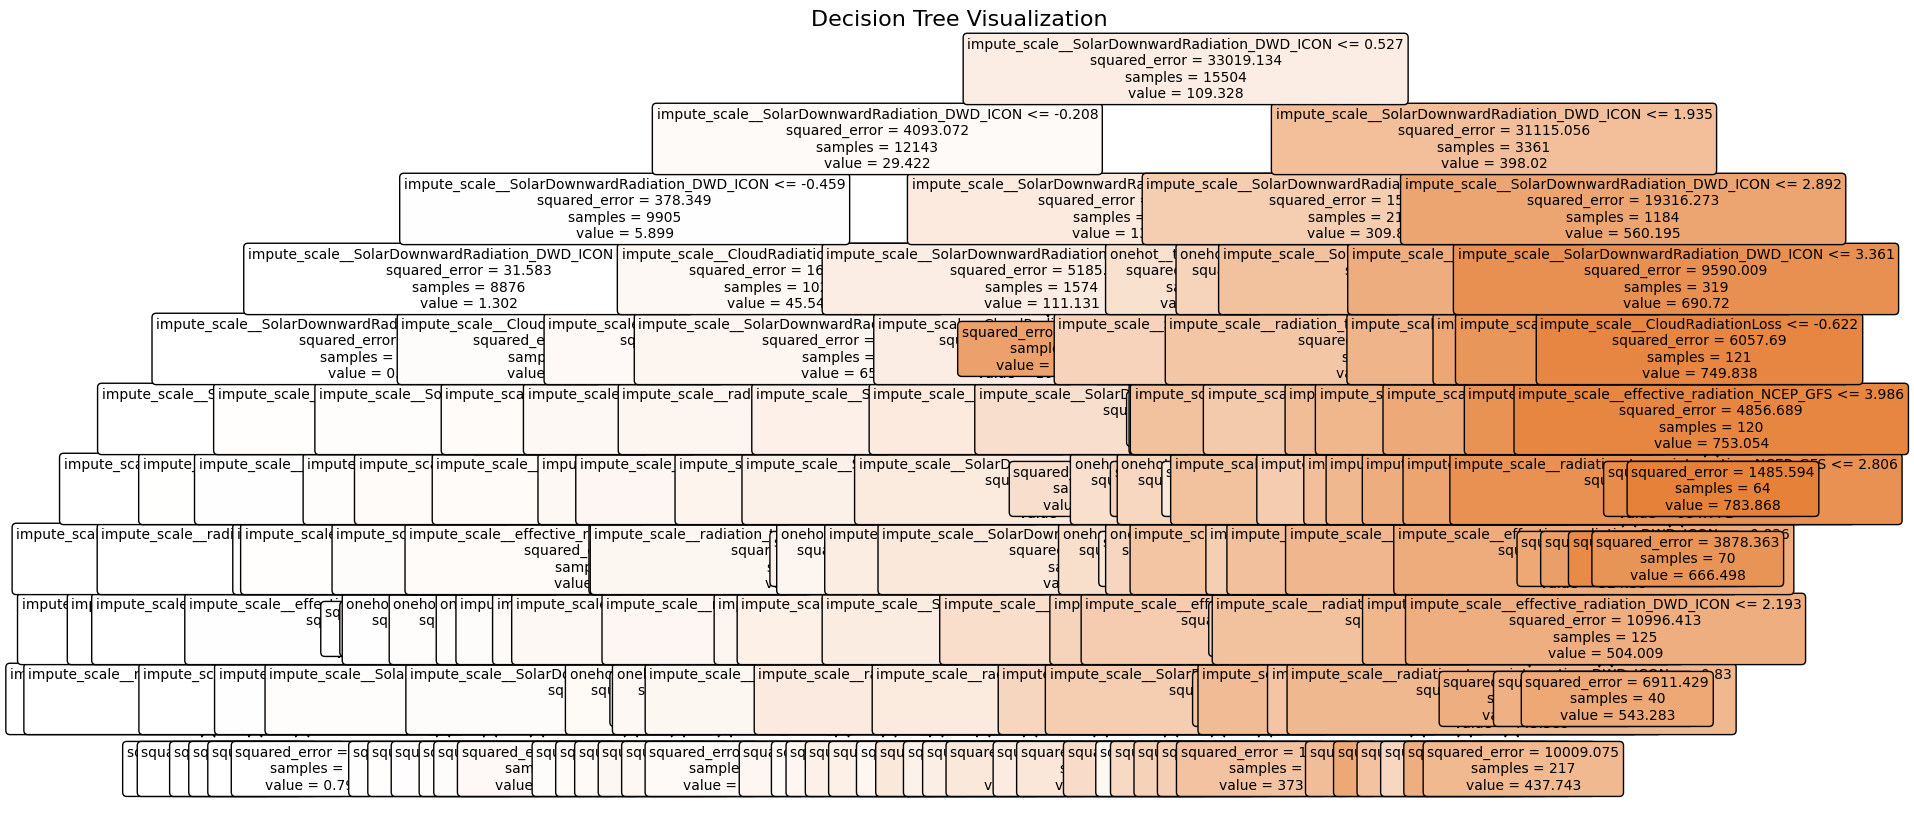

In [21]:
# Zugriff auf das Decision Tree-Modell aus der Pipeline
dt_model = dt_best_model.named_steps['model']

# Extrahieren der Feature-Namen aus dem Preprocessing-Schritt
if hasattr(dt_best_model.named_steps['preprocessing'], 'get_feature_names_out'):
    feature_names = dt_best_model.named_steps['preprocessing'].get_feature_names_out()
else:
    feature_names = X_train.columns

# Visualisierung des Entscheidungsbaums
plt.figure(figsize=(20, 10))  # Festlegen der Größe der Grafik
plot_tree(
    dt_model,
    feature_names=feature_names,  # Anzeige der Feature-Namen
    rounded=True,                 # Abgerundete Knoten
    filled=True,                  # Farbige Knoten basierend auf den Werten
    fontsize=10                   # Schriftgröße
)
plt.title("Decision Tree Visualization", fontsize=16)  # Titel der Grafik
plt.show()


### Ensemble-Modell(Gradient Boosting)

In [22]:
# Definition einer Pipeline mit Preprocessing und GradientBoostingRegressor
pipe = Pipeline([
    ("preprocessing", column_trans),                     # Vorverarbeitung der Eingabedaten
    ("model", GradientBoostingRegressor(random_state=42))  # Gradient Boosting Regressor
])

# Parameter-Grid für die Optimierung des Modells
param_grid = {
    "model__learning_rate": [0.01, 0.1, 0.2],             # Lernrate
    "model__n_estimators": [100, 200, 500],               # Anzahl der Bäume
    "model__max_depth": [3, 5, 10],                       # Maximale Tiefe der Bäume
    "model__max_features": ["sqrt", "log2", None],        # Anzahl der zu verwendenden Features
    "preprocessing__onehot__impute__strategy": ["most_frequent"],  #  für kategorische Variablen
    "preprocessing__impute_scale__impute__strategy": ["mean"]    # für numerische Variablen
}

# GridSearchCV zur Optimierung des Modells
gs = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1)

# Fit des Modells auf die Trainingsdaten
gs.fit(X_train, y_train)

# Bestes Modell, beste Parameter und Trainings-RMSE (basierend auf Kreuzvalidierung)
best_params = gs.best_params_
best_model = gs.best_estimator_
train_rmse = np.sqrt(-gs.best_score_)

# Ausgabe der besten Parameter und des RMSE auf dem Trainingsdatensatz
print("Best Parameters:", best_params)
print("Best RMSE (Cross-Validation):", train_rmse)


Best Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__max_features': 'log2', 'model__n_estimators': 100, 'preprocessing__impute_scale__impute__strategy': 'mean', 'preprocessing__onehot__impute__strategy': 'most_frequent'}
Best RMSE (Cross-Validation): 7.313125583965796


In [23]:
# Vorhersage auf dem Test-Datensatz
y_pred = best_model.predict(X_test)

# Berechnung des RMSE auf dem Test-Datensatz
test_rmse = root_mean_squared_error(y_test, y_pred)

# Ausgabe der Ergebnisse
print("Best Parameters:", best_params)
print("Best RMSE on Training Set (Cross-Validation):", train_rmse)
print("Test RMSE:", test_rmse)


Best Parameters: {'model__learning_rate': 0.1, 'model__max_depth': 5, 'model__max_features': 'log2', 'model__n_estimators': 100, 'preprocessing__impute_scale__impute__strategy': 'mean', 'preprocessing__onehot__impute__strategy': 'most_frequent'}
Best RMSE on Training Set (Cross-Validation): 7.313125583965796
Test RMSE: 46.43136096569316


#### Die wichtigsten Features (Gradient Boosting)

Top-Features nach Wichtigkeit:
                                         Feature Name  Importance
24      impute_scale__SolarDownwardRadiation_DWD_ICON    0.261778
29  impute_scale__radiation_temp_interaction_DWD_ICON    0.261556
26                   impute_scale__CloudRadiationLoss    0.188009
25      impute_scale__SolarDownwardRadiation_NCEP_GFS    0.070005
30  impute_scale__radiation_temp_interaction_NCEP_GFS    0.063776


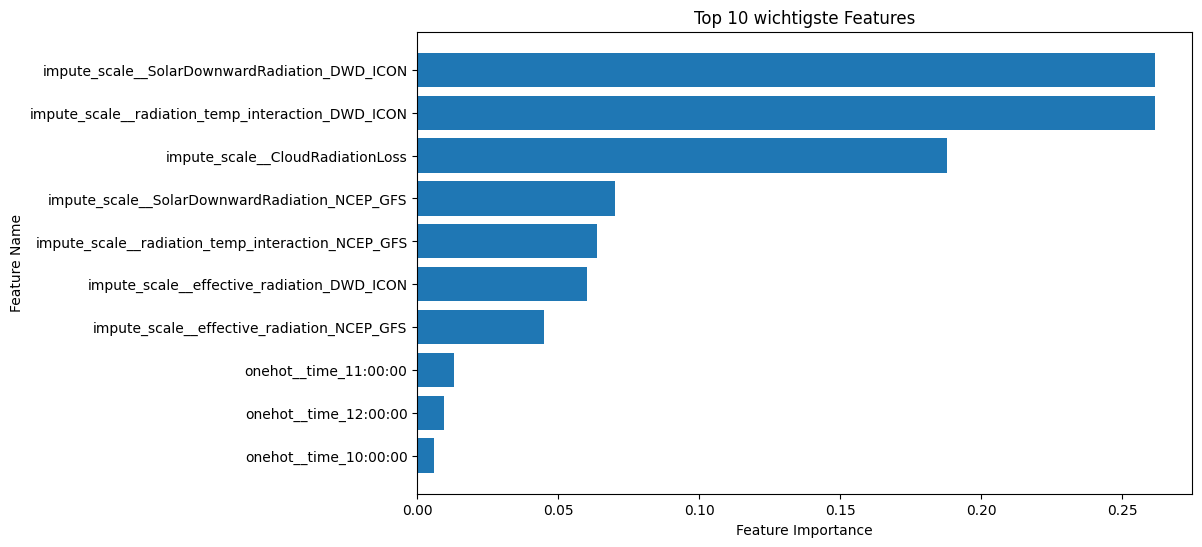

In [24]:
# Zugriff auf das beste Modell aus der Pipeline
best_model = gs.best_estimator_

# Zugriff auf den GradientBoostingRegressor aus der Pipeline
gbr_model = best_model.named_steps['model']

# Extrahieren der Feature-Namen aus dem Preprocessing-Schritt
if hasattr(best_model.named_steps['preprocessing'], 'get_feature_names_out'):
    feature_names = best_model.named_steps['preprocessing'].get_feature_names_out()
else:
    feature_names = X_train.columns

# Zugriff auf die Feature-Importances des GradientBoostingRegressor
feature_importances = gbr_model.feature_importances_

# Erstellung eines DataFrames mit den Importances und den entsprechenden Feature-Namen
importances_df = pd.DataFrame({
    "Feature Name": feature_names,
    "Importance": feature_importances
})

# Sortieren der Features nach ihrer Wichtigkeit in absteigender Reihenfolge
importances_sorted = importances_df.sort_values("Importance", ascending=False)

# Ausgabe der Top-Features
print("Top-Features nach Wichtigkeit:")
print(importances_sorted.head())

# Optional: Visualisierung der Feature-Importances
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(importances_sorted["Feature Name"].head(10), importances_sorted["Importance"].head(10))
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title("Top 10 wichtigste Features")
plt.gca().invert_yaxis()  # Damit die wichtigsten Features oben stehen
plt.show()
